# Section 2 - Bloom Implementation

In [1]:
!pip install bitarray

In [0]:
from bitarray import bitarray

In [6]:
!pip install pyhash

    100% |████████████████████████████████| 604kB 5.8MB/s 
  Running setup.py bdist_wheel for pyhash ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/0a/dd/92/06521a3888c2b46df4a189f3458a78de4d769764f2a5ec639d
Successfully built pyhash


In [0]:
import pyhash

In [0]:
from pyhash import murmur3_32 #importing non-crypographic hash functions
from pyhash import fnv1_32

In [0]:
fnv_hasher = pyhash.fnv1_32()
murmur_hasher = pyhash.murmur3_32()

In [0]:
class Bloom():
  """Bloom Filter"""
  
    def __init__(self,filter_size):
      '''
      First, we initialize the Bloom filter and create a bit array of filter_size entered by the user.
      In addition, we initialize each of the hash functions (Murmur3 and FNV-1) of our filter.
      
      filter_size: size of the vector
      
      '''
        self.filter = filter_size
        self.bit_array = bitarray(filter_size)
        self.bit_array.setall(0) #since bitarray doesn't ensure that all bits are set to 0
        self.hasher1 = pyhash.fnv1_32()
        self.hasher2 = pyhash.murmur3_32()
    
    def get_hashes(self,item):
      '''
      This method returns a list containing the positions computed by each hash function.
      
      item: Item to compute hashes for. 
      
      '''
        hashes = []
        hashes.append(self.hasher1(str(item))% self.filter) #We module each of the hashes with the size of the filter so that all our values are in the same range
        hashes.append(self.hasher2(str(item))% self.filter)
        return hashes
        
    def insert(self,item):
      '''
      The insert method first calls the get_hashes method to compute the positions of the item to be inserted in the bitarray as hashes. 
      Then, the bits are switched to 1 in each position of hashes.   
      
      item: Item to be inserted.
      '''
        hashes = self.get_hashes(item)
        #This method will compute the positions found by passing the new item into each hash function and set them to 1   
        for h in hashes: 
        #We apply the item to each hash functions and switch the bit in the corresponding positions
            pos = int(h)
            self.bit_array[pos] = 1
                   
    def query(self,item):
      
      '''
      
      The query method also calls the get_hashes method to retrieve the positions of the item computed by each hash functions. 
      Then, we iterate through each position to check whether the bit has been switched to 1. The result is 0 if any of the positions in hashes have not been switched.
      
      item: item to be queried
      '''
        hashes = self.get_hashes(item)
        result = 1 #we set the result variable as 1
        for h in hashes:
          pos = int(h)
          if self.bit_array[pos] == 0:
            result = result * 0 #if the bit was not switched, the item wasn't passed to the filter 
        return result #if all the positions have their bits switched to 1, the item may have been inserted before and query yield 1. 
      
    
          

In [0]:
#We will check the bloom filter and its operations

food_names =['salad','sandwich','steak','bread','tuna','sphagetti','pizza','hamburger','sausages','orange juice','cupcake']

sample_filter = Bloom(100)

for i in food_names:
  sample_filter.insert(i)
  


In [221]:
#We will now query for one of the items in food_names.

print(sample_filter.query('salad'))

1


In [222]:
#Now, we will query for one of the items not in food_names.

print(sample_filter.query('Tanha Kate'))

0


In [223]:
#Now, we will check whether a list with the same elements will hash to the same position

food_names =['salad','salad','salad','salad','salad','salad']

new_filter = Bloom(100)

for i in food_names:
  print(new_filter.get_hashes(i))

[29, 68]
[29, 68]
[29, 68]
[29, 68]
[29, 68]
[29, 68]


In [0]:
import uuid

def getRandomString(): #A function to generate random strings which will be useful later. 
  return str(uuid.uuid4())

# Section 3 - Hash Functions


In my choice of hash functions, there are two considerations:



1.   How fast is the computation?
2.   How uniform is the output distribution? 

## Speed

Generally, non-cryptographic hash functions are faster than crypotgraphic hash functions. A cryptographic hash essentially makes it computationally expensive for an active attacker to cause the hash function to do something unwanted such as generate collisions or generate a pre-determined output for a chosen input. For the puposes of this assignment  and for the sake of speed, we will use the non-cryptographic hashes Murmur3 and FNV-1. Let us verify our claim by benchmarking Murmur3 and FNV-1, as well as SHA-256 (a popular cryptographic hash) with random inputs using the standard time module in Python.

As we see below, indeed, Murmur3 and FNV-1 take less time to compute the same hashes as SHA-256.




In [0]:
import hashlib
import time


data = []
for i in range(0, 1000000):
      randomString = getRandomString()
      data.append(randomString)
     


In [102]:
start = time.clock()
for line in data:
  murmur_hasher(line)
print ("The time taken for Murmur3 is ",time.clock() - start, "seconds")

The time taken for Murmur3 is  0.7788259999999987 seconds


In [113]:
start = time.clock()
for line in data:
  fnv_hasher(line)
print ("The time taken for fnv_1 is ",time.clock() - start, "seconds")

The time taken for fnv_1 is  0.9248939999999948 seconds


In [119]:
start = time.clock()
for line in data:
  hashlib.sha256(line.encode('utf-8')).hexdigest()
print ("The time taken for fnv_1 is ",time.clock() - start, "seconds")

The time taken for fnv_1 is  1.054271 seconds


## Uniformity

Uniformity is difficult to measure and requires various statistical measures. Here, we will use a simple method to visualize the distribution of inputs of the Murmur3 and FNV_1 hash functions ranging from 1 to 10000 and module it to 10000, so that they're all in the same range of values. Then, we will plot the keys vs. their hashes in a scatter plot. 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

hasher = murmur_hasher
def single():
    N = 10000
    listy = []
    for i in range(N):
        h = hasher(str(i)) % N
        listy.append((i,h))

    return listy
            
murmur_data = single()


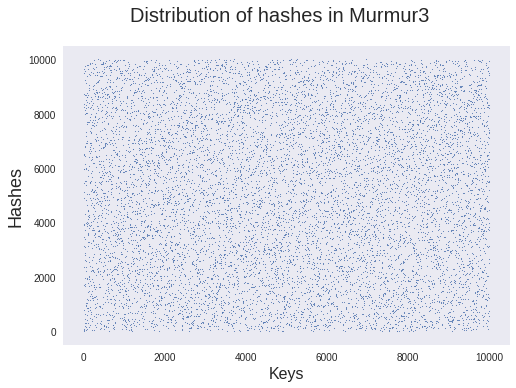

In [146]:
murmur_data = np.array(murmur_data) #we will transform our list of tuples into a numpy array

#Now, we will create three different numpy arrays for each of the data contained in our tuple
murmur_keys = murmur_data.transpose()[0]
murmur_hashes = murmur_data.transpose()[1]
plt.scatter(murmur_keys,murmur_hashes, s = 0.5)
plt.suptitle('Distribution of hashes in Murmur3', fontsize=20)
plt.ylabel('Hashes', fontsize=18)
plt.xlabel('Keys', fontsize=16)
plt.grid(False)

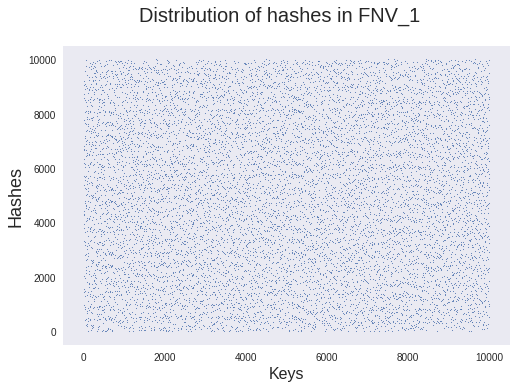

In [147]:
hasher = fnv_hasher
fnv_data = single()
fnv_data = np.array(data) #we will transform our list of tuples into a numpy array

#Now, we will create three different numpy arrays for each of the data contained in our tuple
fnv_keys = fnv_data.transpose()[0]
fnv_hashes = fnv_data.transpose()[1]
plt.scatter(fnv_keys,fnv_hashes, s = 0.5)
plt.suptitle('Distribution of hashes in FNV_1', fontsize=20)
plt.ylabel('Hashes', fontsize=18)
plt.xlabel('Keys', fontsize=16)
plt.grid(False)

As we can observe above, the hash functions appear to distribute the keys uniformly, without any obvious pattern for both Murmur3 and FNV_1. Although this is not sufficient to prove I've selected good hash functions, it's a necessary property. 


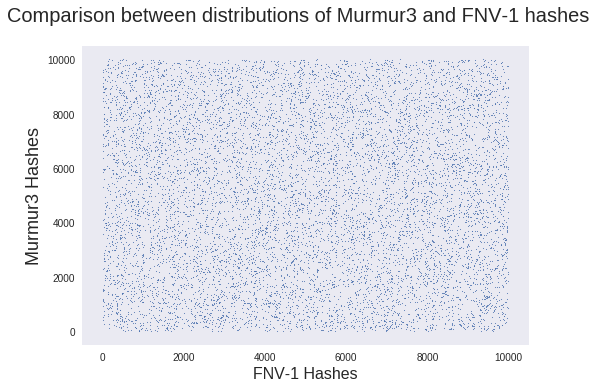

In [152]:
plt.scatter(fnv_hashes,murmur_hashes, s = 0.5)
plt.suptitle('Comparison between distributions of Murmur3 and FNV-1 hashes', fontsize=20)
plt.ylabel('Murmur3 Hashes', fontsize=18)
plt.xlabel('FNV-1 Hashes', fontsize=16)
plt.grid(False)

In addition, we can see that there is no obvious pattern for the hashes computed by each hash function. This is a necessary sign if we're looking for independent hash functions, which is an important assumption to calculate the theoretical false positive rate.

# Section 4

## A) Memory size as a function of the false positive rate


In part 1, we previously derived that the false positive rate ($\epsilon$) for a bloom filter is $\epsilon =(1-e^{\frac{-km}{n}})^k$, where n is the size of the bit array, m is the number of items inserted in the filter and k is the number of hash functions.  To find an explicit relationship between the error rate and size of the bloom filter, we will plug in the optimal k-value where $k=ln(2)*\frac{n}{m}$ into the probability that a bit has not been to 1, which is $e^{\frac{km}{n}}$. 

$e^{\frac{km}{n}} = e^{-ln(2)*\frac{n}{m}*\frac{m}{m}} = e^{-ln(2)} = 0.5$. 

At this point, we can express $\epsilon =(1-e^{\frac{-km}{n}})^k \rightarrow \epsilon = (1-0.5)^k = 0.5^k = 0.5^{ln(2) * \frac{n}{m} } = 0.62^{\frac{n}{m}}$. 

Finally, we can rearrange our new expression from $\epsilon$ to express the memory size (n) as a function of the false positive rate:

$\epsilon = 0.62^{\frac{n}{m}} \rightarrow n = m * \frac{Log(\epsilon)}{Log(0.62)}$

Therefore, theoretically, we expect that the memory size (n) will increase as the false positive rate increases. We will verify these results emprically below:

In [0]:
list_of_tuples = [] #Each element of the list corresponds to a tuple with (memory size, false positive rate)
number_of_insertions = 1000

for m in range (500,20000,1000):
  bloom_filter = None
  false_positives = 0 #initially, the number of false positives is set to 0
  existentKeys = []

	  # Create a Bloom Filter
  bloom_filter = Bloom(m)
	
    #Generate random data and append to bloom filter and existentKeys
  for i in range(0, number_of_insertions):
    randomString = getRandomString()
    bloom_filter.insert(randomString)
    existentKeys.append(randomString)		

	   # Check non-existent keys
  QueryCounter = 100000
  total_negatives = 0 #The false positive rate is defined as the number of false positives / the total number of negatives: https://en.wikipedia.org/wiki/False_positive_rate
    #Therefore, we will initialize a total_negatives variable to keep count of the total number of negatives, which is the sum of the total number of false positives and true negatives
  for i in range(0, QueryCounter):
    randomString = getRandomString()
    if bloom_filter.query(randomString)== 1 and randomString not in existentKeys:
      #if we find randomString in our bloom filter but not in the list of existing keys, we have a false positive result
      false_positives += 1
      total_negatives = total_negatives + 1 #if we have a false positive result, increment total by 1
    elif bloom_filter.query(randomString)==0:
      total_negatives=total_negatives+1 #if we cannot find the randomString in our bloom filter, we have a true negative. Therefore, increment total by 1.
  
  list_of_tuples.append((m,100.0 * float(false_positives)/float(total_negatives)))

In [0]:
import matplotlib.pyplot as plt
import numpy as np

fp_size_data = np.array(list_of_tuples) #we will transform our list of tuples into a numpy array


#Now, we will create three different numpy arrays for each of the data contained in our tuple
memory_size = fp_size_data.transpose()[0]
false_positive_rate = fp_size_data.transpose()[1]

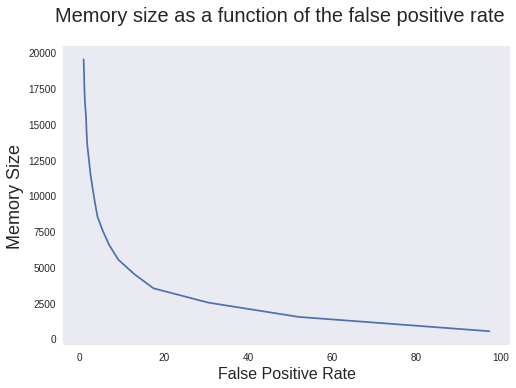

In [273]:
plt.plot(false_positive_rate,memory_size)
plt.suptitle('Memory size as a function of the false positive rate', fontsize=20)
plt.ylabel('Memory Size', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.grid(False)


## B) Memory size as a function of the number of items stored

In the previous section, we derived that the memory size as a function of insertions and false positive rate is: $n = m * \frac{Log(\epsilon)}{Log(0.62)}$. 

Therefore, for a constant false positive rate, we expect the memory size to increase linearly with the number of items stored. 

## C) Access time as a function of the false positive rate

Querying will be constant regardless of the false positive rate since the query operation is proportional to k, the number of hash functions in my implementation of the Bloom filter. Since my implementation uses 2 hash functions, for each element that we want to check set membership for, we have to pass the element through the 2 hash functions and check whether bits have been set to 1 in each of the two positions in our bit array computed by the hash functions. We will verify our results empirically below:

In [0]:
import time 

list_of_tuples = [] #Each element of the list corresponds to a tuple with (query_time, false positive rate)
number_of_insertions = 1000 #The number of insertions is set as a constant value beforehand 
time_taken = 0

for m in range (500,20000,100):
  bloom_filter = None #clear previous bloom filter
  existentKeys = [] #clear previous existentKeys

	  # Create a Bloom Filter
  bloom_filter = Bloom(m)
	
    #Generate random data and append to bloom filter and existentKeys
  for i in range(0, number_of_insertions):
    randomString = getRandomString()
    bloom_filter.insert(randomString)
    existentKeys.append(randomString)		

	   # Check non-existent keys
  false_positives = 0 #initially, the number of false positives is set to 0 nad we will increment the counter for each false positive result we detect below
  QueryCounter = 10000
  total_negatives = 0 #The false positive rate is defined as the number of false positives / the total number of negatives: https://en.wikipedia.org/wiki/False_positive_rate
    #Therefore, we will initialize a total_negatives variable to keep count of the total number of negatives, which is the sum of the total number of false positives and true negatives. 
  
  start = time.clock()#In Windows, time.clock() returns wall-clock seconds elapsed since the first call to this function. We will compute start_time before we enter the for loop to make queries and compute end time after we have iterated through the total number of queries. 
  #For each query, we create a random string using the getRandomString() function. 
  for i in range(0, QueryCounter):
    
    randomString = getRandomString()
    query_result = bloom_filter.query(randomString)
    if query_result== 1 and randomString not in existentKeys:
      #if we find randomString in our bloom filter but not in the list of existing keys, we have a false positive result
      false_positives += 1
      total_negatives = total_negatives + 1 #if we have a false positive result, increment total by 1
    elif query_result ==0:
      total_negatives=total_negatives+1 #if we cannot find the randomString in our bloom filter, we have a true negative. Therefore, increment total by 1.
  
  end = time.clock() #Once we have found the total time taken to iterate through the loop, we will average over the total number of queries to computer the time taken for each query
    
  list_of_tuples.append((end-start/QueryCounter,100.0 * float(false_positives)/float(total_negatives)))
  


In [0]:
time_data = np.array(list_of_tuples) #we will transform our list of tuples into a numpy array


#Now, we will create three different numpy arrays for each of the data contained in our tuple
time = time_data.transpose()[0] #time contains the average time taken for each query
false_positive_rate = time_data.transpose()[1]

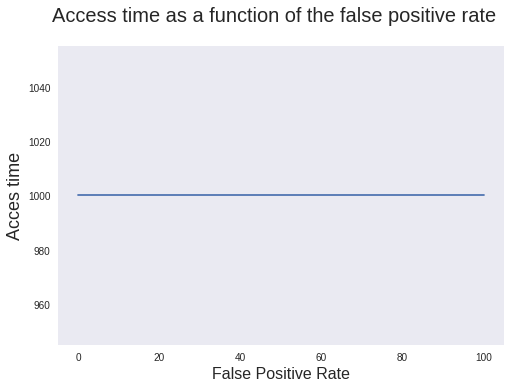

In [370]:
plt.plot(false_positive_rate,np.round(time,-3)) 
plt.suptitle('Access time as a function of the false positive rate', fontsize=20)
plt.ylabel('Acces time', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.grid(False)

## Access time as a function of the number of items stored

Querying will be constant regardless of the number of items stored since the query operation is proportional to k, the number of hash functions in my implementation of the Bloom filter. Since my implementation uses 2 hash functions, for each element that we want to check set membership for, we have to pass the element through the 2 hash functions and check whether bits have been set to 1 in each of the two positions in our bit array computed by the hash functions. We will verify our results empirically below by measuring the average time taken to insert a varying number of keys:

In [0]:
import time 

list_of_tuples = [] #Each element of the list corresponds to a tuple with (query_time, number of insertions)
memory_size = 10000 #We are setting the memory size as a constant figure beforehand
time_taken = 0

for n in range (500,20000,100):
  bloom_filter = None #We clear previous bloom filter and existent keys
  existentKeys = []


	  # Create a Bloom Filter
  bloom_filter = Bloom(memory_size)
	
    #Generate random data and append to bloom filter and existentKeys
  start = time.clock()#In Windows, time.clock() returns wall-clock seconds elapsed since the first call to this function. 
  #We will compute start_time before we enter the for loop to make queries and compute end time after we have iterated through the total number of queries.
  for i in range(0, n):   #For each query, we create a random string using the getRandomString() function. 
    randomString = getRandomString()
    bloom_filter.insert(randomString)
    existentKeys.append(randomString)		
    
  end = time.clock()##Once we have found the total time taken to iterate through the loop, we will average over the total number of queries to computer the time taken for each query
    
  list_of_tuples.append((end-start/QueryCounter,n))
  


In [0]:
timeinsert_data = np.array(list_of_tuples) #we will transform our list of tuples into a numpy array.


#Now, we will create three different numpy arrays for each of the data contained in our tuple
timeinsert = timeinsert_data.transpose()[0] #timeinsert contains the average time taken for a query
insert_data = timeinsert_data.transpose()[1] #insert_data constains the number of insertions

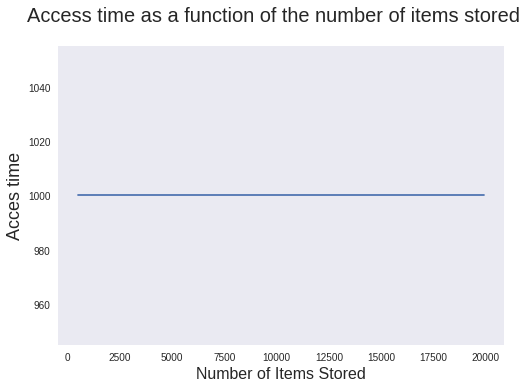

In [377]:
plt.plot(insert_data,np.round(timeinsert,-3)) 
plt.suptitle('Access time as a function of the number of items stored', fontsize=20)
plt.ylabel('Acces time', fontsize=18)
plt.xlabel('Number of Items Stored', fontsize=16)
plt.grid(False)

# Section 5

In part 1, we previously derived that the false positive rate ($\epsilon$) for a bloom filter is $\epsilon =(1-e^{\frac{-km}{n}})^k$, where n is the size of the bit array, m is the number of items inserted in the filter and k is the number of hash functions. Therefore, we can hypothesize that:
 


1.  The probability of false positives decreases as n (the number of bits in the array) increases
2.   The probability of false positives increases as m (the number of inserted elements) increases. 


 In all our simulations, k i.e. the number of hash functions is set to 2. 

In [0]:
from math import exp

def theoretical_fp(memory_size,elements_inserted):
  '''
  
  This function calculates the theoretical false positives rates for a Bloom filter with 2 hash functions and different combinations of memory size and number of elements inserted using the formula above.
  
  '''
  return (1-exp(-2*elements_inserted/memory_size))**2
  

## Memory size as a function of the false positive rate

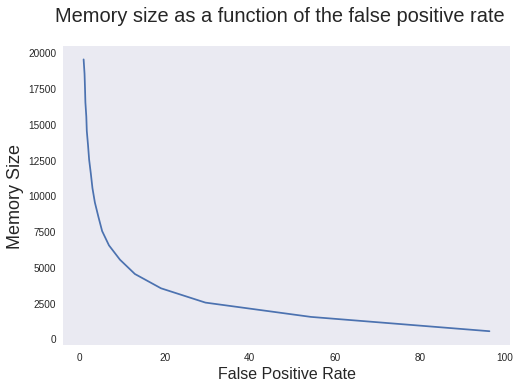

In [292]:
plt.plot(false_positive_rate,memory_size)
plt.suptitle('Memory size as a function of the false positive rate', fontsize=20)
plt.ylabel('Memory Size', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.grid(False)


As we saw in Section 4(A), the probability of false positives indeed decreases as n (the number of bits in the array) increases, as we expected in hypothesis 1.

## Number of items stored as a function of the false positive rate 

In [0]:
list_of_tuples = [] #Each element of the list corresponds to a tuple with (memory size, false positive rate)
memory_size = 100000

for n in range (500,20000,1000):
  bloom_filter = None
  false_positives = 0 #initially, the number of false positives is set to 0
  existentKeys = []

	  # Create a Bloom Filter
  bloom_filter = Bloom(memory_size)
	
    #Generate random data and append to bloom filter and existentKeys
  for i in range(0, n):
    randomString = getRandomString()
    bloom_filter.insert(randomString)
    existentKeys.append(randomString)		

	   # Check non-existent keys
  QueryCounter = 100000
  total_negatives = 0 #The false positive rate is defined as the number of false positives / the total number of negatives: https://en.wikipedia.org/wiki/False_positive_rate
    #Therefore, we will initialize a total_negatives variable to keep count of the total number of negatives, which is the sum of the total number of false positives and true negatives
  for i in range(0, QueryCounter):
    randomString = getRandomString()
    if bloom_filter.query(randomString)== 1 and randomString not in existentKeys:
      #if we find randomString in our bloom filter but not in the list of existing keys, we have a false positive result
      false_positives += 1
      total_negatives = total_negatives + 1 #if we have a false positive result, increment total by 1
    elif bloom_filter.query(randomString)==0:
      total_negatives=total_negatives+1 #if we cannot find the randomString in our bloom filter, we have a true negative. Therefore, increment total by 1.
  
  list_of_tuples.append((n,100.0 * float(false_positives)/float(total_negatives)))

In [0]:
fp_items_data = np.array(list_of_tuples) #we will transform our list of tuples into a numpy array


#Now, we will create three different numpy arrays for each of the data contained in our tuple
items_inserts = fp_items_data.transpose()[0]
items_fp_rate = fp_items_data.transpose()[1]

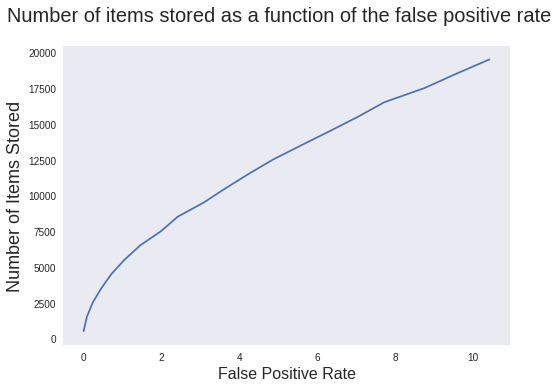

In [284]:
plt.plot(items_fp_rate,items_inserts)
plt.suptitle('Number of items stored as a function of the false positive rate', fontsize=20)
plt.ylabel('Number of Items Stored', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=16)
plt.grid(False)

In this graph, we can observe that the false positive rate is indeed increasing with increasing number of items stored, as we hypothesized earlier.

## Theoretical values and Practical Results

Now, we will compare the theoretical results for vary memory sizes and varying number of insertions with the practical results we obtained earlier. 

In [0]:
theoretical_falses = [] #Each element of the list will contain the theoretical false positive rates for a constant number of insertions and an increasing memory size. 
number_of_insertions = float(1000)

for m in range (500,20000,1000): #Note that we have to ensure to iterate over the same range of memory sizes which we used to compute the memory sizes as a function of the practical false positive rates.
  theoretical_falses.append(theoretical_fp(float(m),number_of_insertions)*100)


In [0]:
theoretical_falses = np.array(theoretical_falses)


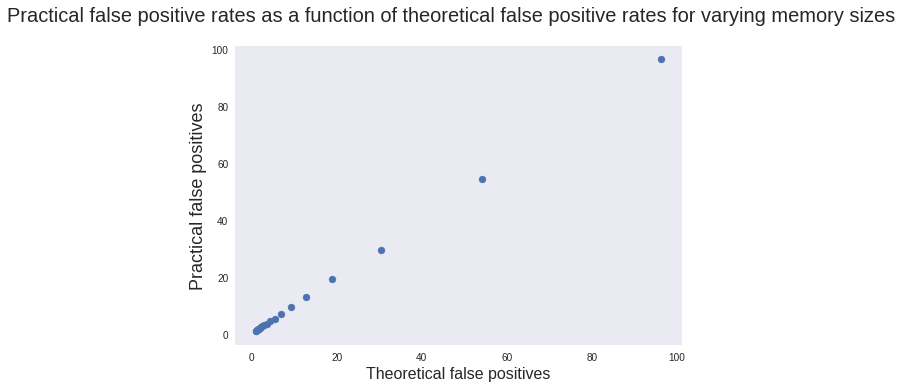

In [296]:
plt.scatter(theoretical_falses,false_positive_rate)
plt.suptitle('Practical false positive rates as a function of theoretical false positive rates for varying memory sizes', fontsize=20)
plt.ylabel('Practical false positives', fontsize=18)
plt.xlabel('Theoretical false positives', fontsize=16)
plt.grid(False)


In [0]:
theoretical_falses = [] #Each element of the list will contain the theoretical false positive rates for a constant memory size and an increasing number of insertions. 
memory_size = float(100000)

for n in range (500,20000,1000): #Note that we have to ensure to iterate over the same range of insertions which we used to compute the number of insertions as a function of the practical false positive rates.
  theoretical_falses.append(theoretical_fp(memory_size,float(n))*100)


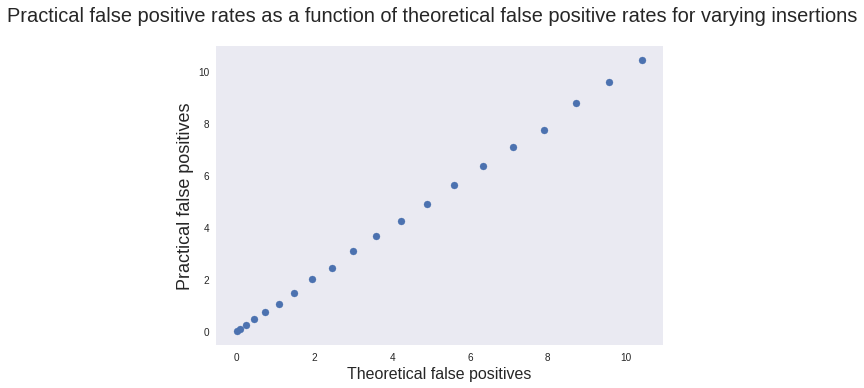

In [298]:
plt.scatter(theoretical_falses,items_fp_rate)
plt.suptitle('Practical false positive rates as a function of theoretical false positive rates for varying insertions', fontsize=20)
plt.ylabel('Practical false positives', fontsize=18)
plt.xlabel('Theoretical false positives', fontsize=16)
plt.grid(False)


As we can see above, my implementation's false positive rate almost exactly matches the theoretical false positive rates for both constant insertions and varying memory sizes as well as constant memory sizes and varying insertions. Note that my Bloom filter implementations used 2 hash functions to measure the false positive rates. 